In [1]:
import torch
from builtins import range
from __future__ import division
from __future__ import print_function
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.metrics import classification_report, log_loss
from timeit import default_timer as timer
import gc
import sys
import skimage.transform as sktr
from torchvision.models import vgg16, alexnet
import torchvision
import sklearn.linear_model as lm
from sklearn.preprocessing import normalize
%matplotlib inline

/Users/penzardmitry/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


 Задание: выкинуть последний слой из vgg / alexnet и обучить линейную регрессиию на выходах полученных сетей.
Например, для mnist.

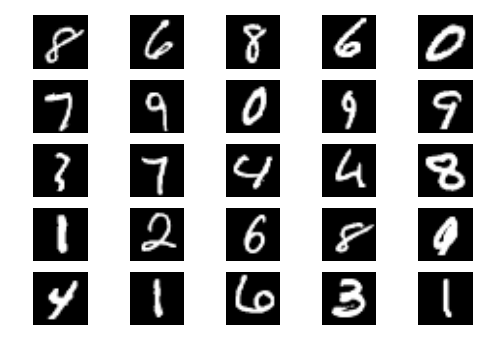

In [2]:
# обратите внимание, что данные имеют размерость examples x channels x w x h
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(777)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)


images_train = images_train
labels_train = labels_train
images_test = images_test
labels_test = labels_test


for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')

In [3]:
alex_net = alexnet(pretrained=True)
print (alex_net.classifier)
print( alex_net.features)
#torch
#All pre-trained models expect input images normalized in the same way, 
#i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be atleast 224.
#The images have to be loaded in to a range of [0, 1]
#and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
mean_norm = 0.485
mean_std = 0.229

Sequential (
  (0): Dropout (p = 0.5)
  (1): Linear (9216 -> 4096)
  (2): ReLU (inplace)
  (3): Dropout (p = 0.5)
  (4): Linear (4096 -> 4096)
  (5): ReLU (inplace)
  (6): Linear (4096 -> 1000)
)
Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)


In [4]:
#10, 3, 224, 224
def image_transform(img):
    img = np.squeeze(img)
    img = sktr.resize(img, (224, 224), preserve_range = True)
    img = np.repeat(img[np.newaxis, :,:], 3, axis = 0)
    mx = np.max(img)
    img = ( img - mean_norm) / mean_std
    return img

def process_mnist(img_arr):
    processed = np.zeros(shape = (img_arr.shape[0], 3, 224, 224))
    #sys.stdout.write("Start resizing images\n")
    for i in range(img_arr.shape[0]):
        #if i % 100 == 0:
            #sys.stdout.write("\rImage num {}".format(i))
        processed[i] = image_transform(img_arr[i])
    return processed
    #sys.stdout.write("\nDone\n")
    
    
def precompute_alex_features(X, batch_size = 50):
    sys.stdout.write("Start precomputing features\n")
    computed = np.zeros(shape = (X.shape[0], 9216))
    for ind, i in enumerate(range(0, X.shape[0], batch_size), 1):
        sys.stdout.write("\rBatch num {}".format(ind))
        sys.stdout.flush()
        batch = process_mnist(X[i:i+batch_size])
        batch = torch.from_numpy(batch).type(torch.FloatTensor)
        batch = Variable(batch, requires_grad = False)
        alex_train_features = alex_net.features.forward(batch)
        alex_train_features = alex_train_features.view(alex_train_features.size(0), -1)
        alex_train_features = alex_train_features.data.numpy()
        alex_train_features  = normalize(alex_train_features )
        computed[i:i+batch_size] = alex_train_features
    sys.stdout.write("\nDone\n")
    return computed

In [32]:
# to avoid long calculations of AlexNet forward
print ("Computing train features")
images_train_ = precompute_alex_features(images_train)
print ("Computing test features")
images_test_ = precompute_alex_features(images_test)

Computing train features
Start precomputing features
Batch num 1050
Done
Computing test features
Start precomputing features
Batch num 350
Done


In [33]:
images_train = images_train_
images_test = images_test_

In [34]:

np.save('train_alex_processed.npy', images_train)
np.save('train_labels.npy', labels_train)
np.save('text_alex_processed.npy', images_test)
np.save('test_labels.npy', labels_test)

In [5]:
images_train = np.load('train_alex_processed.npy')
labels_train = np.load('train_labels.npy')
images_test = np.load('text_alex_processed.npy')
labels_test = np.load('test_labels.npy')

Попробуем логистическую регрессию

In [35]:
max_epoch_num = 15
batch_size = 50

model = lm.SGDClassifier(loss="log")
train_loss = list()
test_loss = list()

loss = None
classes = np.arange(10)
for epoch_num in range(max_epoch_num): 
    sys.stdout.write("Start epoch num : {}\n".format(epoch_num + 1))
    sys.stdout.write("  Training set\n")
    for ind, i in enumerate(range(0, len(images_train), batch_size), 1):
        sys.stdout.write("\r  ")
        sys.stdout.write("  Batch num {}, previous loss is {}".format(ind, loss))
        batch = images_train[i:(i+batch_size), :]
        labels = labels_train[i:(i+batch_size)]
        model.partial_fit(batch, labels, classes=classes)
        loss = log_loss(labels, model.predict_proba(batch), labels=classes)
        train_loss.append(loss)
    sys.stdout.write("\n  Done\n")
    sys.stdout.write("  Test set")
    for ind, i in enumerate(range(0, len(images_test), batch_size), 1):
        sys.stdout.write("\r  ")
        sys.stdout.write("  Batch num {}, previous loss is {}".format(ind, loss))
        batch = images_test[i:(i+batch_size), :]
        labels = labels_test[i:(i+batch_size)]
        loss = log_loss(labels, model.predict_proba(batch), labels=classes)
        test_loss.append(loss)
    sys.stdout.write("\n  Done\n")
    sys.stdout.write("Done\n")



Start epoch num : 1
  Training set
    Batch num 1050, previous loss is 0.379739088952
  Done
    Batch num 350, previous loss is 0.379313275301
  Done
Done
Start epoch num : 2
  Training set
    Batch num 1050, previous loss is 0.389432328969
  Done
    Batch num 350, previous loss is 0.371057492662
  Done
Done
Start epoch num : 3
  Training set
    Batch num 1050, previous loss is 0.393083593545
  Done
    Batch num 350, previous loss is 0.36606794863
  Done
Done
Start epoch num : 4
  Training set
    Batch num 1050, previous loss is 0.396671511862
  Done
    Batch num 350, previous loss is 0.363982501988
  Done
Done
Start epoch num : 5
  Training set
    Batch num 1050, previous loss is 0.397801711036
  Done
    Batch num 350, previous loss is 0.361940142242
  Done
Done
Start epoch num : 6
  Training set
    Batch num 1050, previous loss is 0.399361126662
  Done
    Batch num 350, previous loss is 0.361161233748
  Done
Done
Start epoch num : 7
  Training set
    Batch num 1050, prev

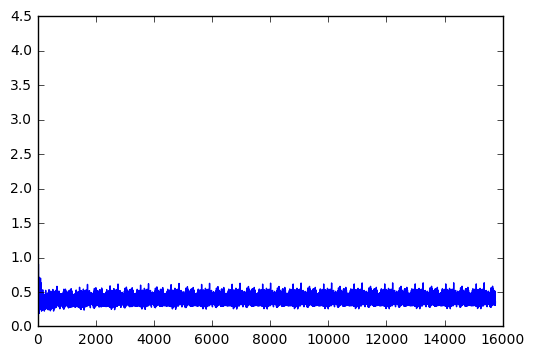

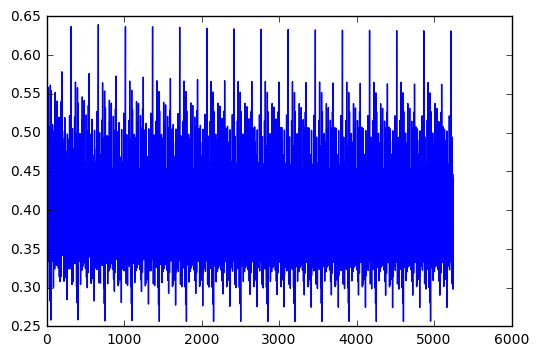

In [37]:


plt.plot(np.arange(len(train_loss)), np.array(train_loss))
plt.show()
plt.plot(np.arange(len(test_loss)), np.array(test_loss))
plt.show()

In [39]:
model.score(images_test, labels_test)

0.94702857142857144

In [11]:
def Neuro_Arch1():
    return nn.Sequential(
        nn.Linear(9216, 200),
        nn.Tanh(),
        nn.Linear(200, 10),
        nn.Softmax()
    )

def Neuro_Arch2():
    return nn.Sequential(
        nn.Linear(9216, 1000),
        nn.ReLU(),
        nn.Linear(1000, 200),
        nn.ReLU(),
        nn.Linear(200, 10),
        nn.Softmax()
    )

def Neuro_Arch3():
    return nn.Sequential(
        nn.Linear(9216, 1024),
        nn.ReLU(),
        nn.Dropout(p = 0.4),
        nn.Linear(1000, 512),
        nn.ReLU(),
        nn.Dropout(p = 0.4),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p = 0.4),
        nn.Linear(256, 10),
        nn.Softmax()
    )

In [15]:
#was copied from previous homework
def print_work_time(func):
    def wrapper(*args, **kwargs):
        start = timer()
        result = func(*args, **kwargs)
        end = timer()
        print("Execution take {}".format(end - start))
        return result
    return wrapper

@print_work_time
def learn_on_model(X, Y, model, loss_fn, X_test = None, Y_test = None, learning_rate = 1e-2, 
                   batch_size = 100, max_epoch_num = 1, min_loss = 1e-5): 

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    loss = 1000
    epoch_num = 0
     
    loss_arr = list()

    test_loss_arr = list() if not (type(X_test) is None) else None
    tot_err = 10**6
    X = X.copy()
    Y = Y.copy()

    while epoch_num < max_epoch_num:
        model = model.eval()
        #perm = np.random.permutation(X.shape[0])
        #X = X[perm]
        #Y = Y[perm]
        tot_err = 0
        sys.stdout.write("Epoch {} ...\n".format(epoch_num + 1))
        sys.stdout.write("Train\n")
        for bn, start in enumerate(xrange(0, X.shape[0], batch_size)):
            optimizer.zero_grad()
            if bn % 100 == 0:
                sys.stdout.write("\rBatch {}".format(bn))
            X_CUR = Variable(torch.from_numpy(X[start:start + batch_size]).type(torch.FloatTensor),
                            requires_grad = True)
            Y_CUR = Variable(torch.from_numpy(Y[start:start + batch_size]), requires_grad=False)
            output =  model.forward(X_CUR)
            loss = loss_fn(output, Y_CUR)
            loss_arr.append(loss.data.tolist()[0])
            tot_err += loss.data.tolist()[0]
            loss.backward()
            optimizer.step()
            del loss
            del X_CUR
            del Y_CUR
            del output

        sys.stdout.write("\nTest\n")
        if not (type(X_test) is None):
            model = model.train()
            for bn, start in enumerate(xrange(0, X_test.shape[0], batch_size)):
                if bn % 100 == 0:
                    sys.stdout.write("\rBatch {}".format(bn))
                X_CUR = Variable(torch.from_numpy(X_test[start:start + batch_size]).type(torch.FloatTensor),
                                requires_grad = True)
                Y_CUR = Variable(torch.from_numpy(Y_test[start:start + batch_size]), requires_grad = False)
                y_pred = model.forward(X_CUR)
                loss = loss_fn(y_pred, Y_CUR)
                test_loss_arr.append(loss.data.tolist()[0])
                del X_CUR
                del Y_CUR
                del y_pred
                del loss
        sys.stdout.write("\n")   
            
        epoch_num += 1
        gc.collect() # only this've helped to save process from beeing kill
    model = model.train()
    return np.array(loss_arr), np.array(test_loss_arr)

def draw_plots(model, loss_arr, layer_arr, test_loss_arr, show_weights = False):
    x = np.arange(loss_arr.shape[0]);
    number_of_plots = 1 + sum(len(x) for x in layer_arr)
    gridSize = number_of_plots
    plt.figure(figsize=(15, 6 * number_of_plots))
    
    plotId = 1
    subpl = plt.subplot(gridSize, 1, plotId)
    if not type(test_loss_arr) is None:
        subpl.plot(x, loss_arr, x, test_loss_arr)
        subpl.legend(["Train", "Test"])
    else:
        subpl.plot(x, loss_arr)
    subpl.set_xticks(range(x.shape[0]))
    subpl.set_title("Loss function")
    subpl.set_xlabel("Epoch num")
    subpl.set_ylabel("Loss func")
    if show_weights:
        for ind1, child in enumerate(model.children()):
            for ind2, key in enumerate(child.state_dict().keys()):
                plotId += 1
                subpl = plt.subplot(gridSize, 1, plotId)
                y = layer_arr[ind1][ind2]
                subpl.plot(x, y)

                subpl.set_xticks(range(x.shape[0]))
                subpl.set_title("Layer {} : {} gradient norm".format(ind1 + 1, key))
                subpl.set_xlabel("Epoch num")
                subpl.set_ylabel(key + "_grad")
    
    plt.show()

from sklearn.metrics import classification_report

def make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST, batch_size = 100):
    model = model.eval()
    print ("Train report")
    y_predicted = np.zeros(shape = (Y_TRAIN.shape[0], 10))
    
    for bn, start in enumerate(xrange(0, X_TRAIN.shape[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(torch.from_numpy(X_TRAIN[start:start + batch_size]).type(torch.FloatTensor) )
        
        
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TRAIN.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TRAIN.tolist()) == indices))
    
    print ("Test report")
    y_predicted = np.zeros(shape = (Y_TEST.shape[0], 10))
    for bn, start in enumerate(xrange(0, X_TEST.shape[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(torch.from_numpy(X_TEST[start:start + batch_size]).type(torch.FloatTensor))
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
        del X_CUR
        
    
    
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TEST.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TEST.tolist()) == indices))

    


In [77]:
model = Neuro_Arch1()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model( images_train,
                                          labels_train, 
                                          model, loss_fn,
                                          images_test,
                                          labels_test,\
                                          learning_rate,\
                                          max_epoch_num=5, 
                                          batch_size = 50)


Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Epoch 2 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Epoch 3 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Epoch 4 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Epoch 5 ...
Train Ba

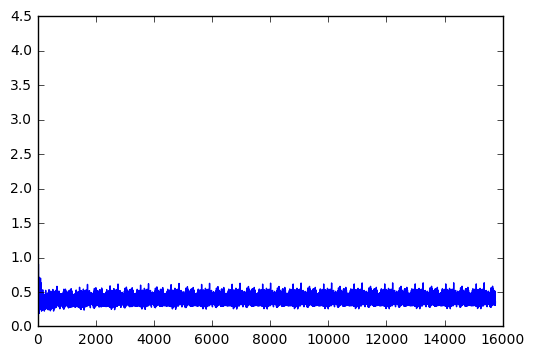

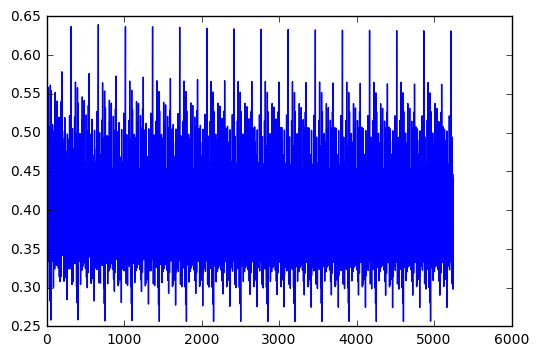

In [78]:

plt.plot(np.arange(len(train_loss)), np.array(train_loss))
plt.show()
plt.plot(np.arange(len(test_loss)), np.array(test_loss))
plt.show()

In [80]:
make_classification_report(model, images_train, labels_train, images_test, labels_test)


Train report
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      5218
          1       0.98      0.98      0.98      5894
          2       0.96      0.98      0.97      5218
          3       0.98      0.96      0.97      5388
          4       0.97      0.98      0.97      5116
          5       0.98      0.97      0.98      4777
          6       0.98      0.98      0.98      5107
          7       0.96      0.96      0.96      5466
          8       0.96      0.97      0.96      5111
          9       0.97      0.95      0.96      5205

avg / total       0.97      0.97      0.97     52500

Accuracy 0.971504761905
Test report
Batch 0
Batch 100
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      1685
          1       0.98      0.98      0.98      1983
          2       0.96      0.98      0.97      1772
          3       0.97 

In [16]:
model = Neuro_Arch2()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model( images_train,
                                          labels_train, 
                                          model, loss_fn,
                                          images_test,
                                          labels_test,\
                                          learning_rate,\
                                          max_epoch_num=5, 
                                          batch_size = 50)


Epoch 1 ...
Train
Batch 1000
Test
Batch 300
Epoch 2 ...
Train
Batch 1000
Test
Batch 300
Epoch 3 ...
Train
Batch 1000
Test
Batch 300
Epoch 4 ...
Train
Batch 1000
Test
Batch 300
Epoch 5 ...
Train
Batch 1000
Test
Batch 300
Execution take 1907.20778608


In [17]:
make_classification_report(model, images_train, labels_train, images_test, labels_test)

Train report
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      5218
          1       0.99      0.99      0.99      5894
          2       0.98      0.99      0.98      5218
          3       0.99      0.98      0.98      5388
          4       0.98      0.98      0.98      5116
          5       0.99      0.98      0.99      4777
          6       0.99      0.99      0.99      5107
          7       0.97      0.98      0.98      5466
          8       0.98      0.98      0.98      5111
          9       0.97      0.97      0.97      5205

avg / total       0.98      0.98      0.98     52500

Accuracy 0.982819047619
Test report
Batch 0
Batch 100
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      1685
          1       0.99      0.99      0.99      1983
          2       0.98      0.98      0.98      1772
          3       0.98 